# **YouTube data analytics**

In [ ]:
# Import libraries
import praw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import gensim
from gensim import corpora
from nltk.stem.wordnet import WordNetLemmatizer

import os
from dotenv import load_dotenv
load_dotenv()

filepath=os.environ["DATA-FOLDER-PATH"]

In [ ]:
# Load your DataFrame
data = f'{filepath}/data_combined.csv'
video_df = pd.read_csv(data)

In [ ]:
com_tea = f'{filepath}/data_tea_comments.csv'
com_coffee = f'{filepath}/data_coffee_comments.csv'

com_tea = pd.read_csv(com_tea)
com_coffee = pd.read_csv(com_coffee)

### **Pre-processing and Exploration**

In [ ]:
# Convert the column names to lowercase
video_df.columns = video_df.columns.str.lower()
video_df.head(10)

title  \
0   The History Of Tea - Historia [Animated History]   
1           Tea: How Britain Screwed India and China   
2  The History of Tea | The Origin Of Tea | Tea's...   
3  Robert Fortune on How Tea Was Stolen From the ...   
4  How did tea become so popular in Great Britain...   
5                             A brief history of tea   
6                         Commoner Queens of England   
7             Anne, Queen of Great Britain & Ireland   
8         The History Of Afternoon Tea | Documentary   
9  An Introduction to Tea in East Asia - ASMR His...   

                                 channel          published at     video id  \
0                   Mechanix Illustrated  2023-02-19T21:28:20Z  TX78tKMdJsA   
1                            Elliot Sang  2023-09-08T17:00:11Z  2-1obrIBYN0   
2                             KidsMathTV  2023-01-09T11:03:57Z  N6uzMv9XpKY   
3                         SLICE Full Doc  2024-07-03T12:30:21Z  YbqtP-lH734   
4                       Absolute History  2023-04-05T21:00:24Z  uhLl7YxQnjA   
5                                   Neom  2022-10-25T19:00:04Z  9wfj-E5s-ws   
6  History Tea Time with Lindsay Holiday  2024-04-16T16:00:05Z  8LEoH6SSCwM   
7  History Tea Time with Lindsay Holiday  2024-09-03T16:00:41Z  jcNBX4UvHmk   
8                    HistoricHospitality  2024-02-23T17:00:11Z  caFzG39lBmE   
9                         ASMR Historian  2024-02-28T07:00:10Z  TUvEMzi7r10   

  likes       dislikes comments post type  
0   287  Not available       27       tea  
1  5730  Not available      357       tea  
2   108  Not available        0       tea  
3  1552  Not available      192       tea  
4  7291  Not available       85       tea  
5    94  Not available       65       tea  
6  6196  Not available      556       tea  
7  3777  Not available      222       tea  
8   192  Not available       35       tea  
9    67  Not available       13       tea

In [ ]:
video_df.shape

(9679, 8)

In [ ]:
video_df['published at'] = pd.to_datetime(video_df['published at'])

In [ ]:
video_df['date'] = video_df['published at'].dt.date
video_df['time'] = video_df['published at'].dt.time

In [ ]:
video_df = video_df.drop(columns=['published at'])
video_df = video_df.drop(columns=['dislikes'])

In [ ]:
video_df.head(10)

title  \
0   The History Of Tea - Historia [Animated History]   
1           Tea: How Britain Screwed India and China   
2  The History of Tea | The Origin Of Tea | Tea's...   
3  Robert Fortune on How Tea Was Stolen From the ...   
4  How did tea become so popular in Great Britain...   
5                             A brief history of tea   
6                         Commoner Queens of England   
7             Anne, Queen of Great Britain & Ireland   
8         The History Of Afternoon Tea | Documentary   
9  An Introduction to Tea in East Asia - ASMR His...   

                                 channel              published at  \
0                   Mechanix Illustrated 2023-02-19 21:28:20+00:00   
1                            Elliot Sang 2023-09-08 17:00:11+00:00   
2                             KidsMathTV 2023-01-09 11:03:57+00:00   
3                         SLICE Full Doc 2024-07-03 12:30:21+00:00   
4                       Absolute History 2023-04-05 21:00:24+00:00   
5                                   Neom 2022-10-25 19:00:04+00:00   
6  History Tea Time with Lindsay Holiday 2024-04-16 16:00:05+00:00   
7  History Tea Time with Lindsay Holiday 2024-09-03 16:00:41+00:00   
8                    HistoricHospitality 2024-02-23 17:00:11+00:00   
9                         ASMR Historian 2024-02-28 07:00:10+00:00   

      video id likes       dislikes comments post type        date      time  
0  TX78tKMdJsA   287  Not available       27       tea  2023-02-19  21:28:20  
1  2-1obrIBYN0  5730  Not available      357       tea  2023-09-08  17:00:11  
2  N6uzMv9XpKY   108  Not available        0       tea  2023-01-09  11:03:57  
3  YbqtP-lH734  1552  Not available      192       tea  2024-07-03  12:30:21  
4  uhLl7YxQnjA  7291  Not available       85       tea  2023-04-05  21:00:24  
5  9wfj-E5s-ws    94  Not available       65       tea  2022-10-25  19:00:04  
6  8LEoH6SSCwM  6196  Not available      556       tea  2024-04-16  16:00:05  
7  jcNBX4UvHmk  3777  Not available      222       tea  2024-09-03  16:00:41  
8  caFzG39lBmE   192  Not available       35       tea  2024-02-23  17:00:11  
9  TUvEMzi7r10    67  Not available       13       tea  2024-02-28  07:00:10

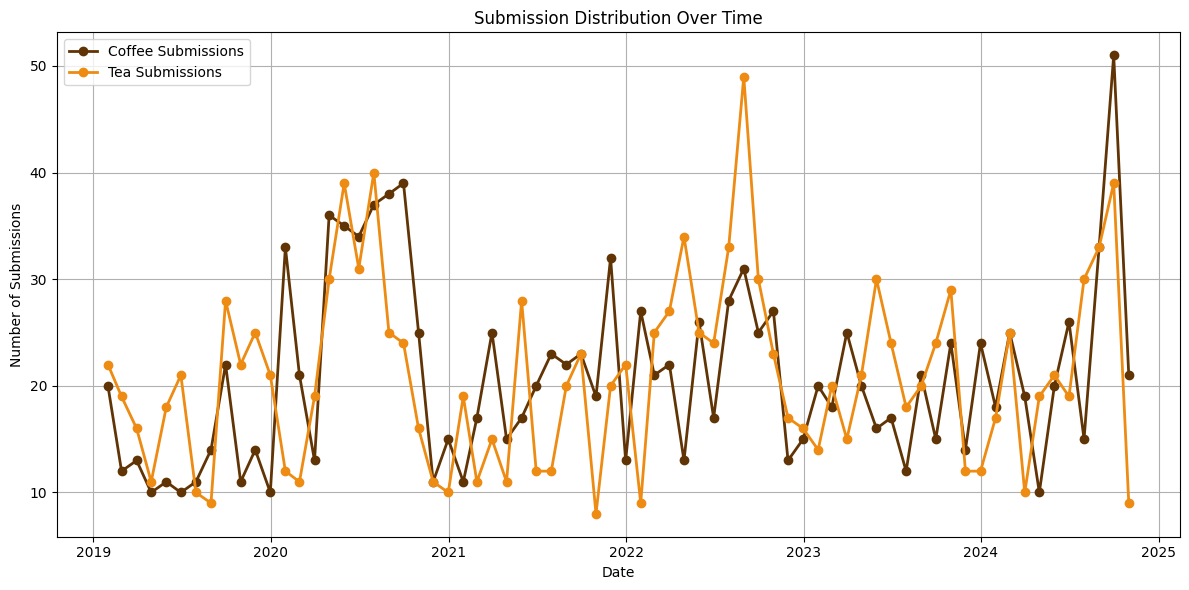

In [ ]:
video_df['date'] = pd.to_datetime(video_df['date'])

filtered_df = video_df[(video_df['date'] >= '2019-01-01') & (video_df['date'] <= '2024-12-31')]
submission_count = filtered_df.groupby(['post type', pd.Grouper(key='date', freq='M')]).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))

colors = {'tea': '#ed8b12', 'coffee': '#613405'}
for post_type, counts in submission_count.iterrows():
    plt.plot(counts.index, counts, marker='o', linestyle='-', linewidth=2,
             label=f"{post_type.capitalize()} Submissions", color=colors[post_type])

plt.title('Submission Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Submissions')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

In [ ]:
# All posts
collected_posts = []

tea_unprocessed_token_lists = []
tea_processed_token_lists = []

coffee_unprocessed_token_lists = []
coffee_processed_token_lists = []

tea = 'tea'
coffee = 'coffee'
num_beverages = 2

### **Pre-processing and Exploration**

In [ ]:
stop_words = set(stopwords.words('english')) | {'http', 'https', 'www', 'com', 'reddit'}

In [ ]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    filtered_words = [word for word in tokens if word not in stop_words and 1 < len(word) <= 15]
    return ' '.join(filtered_words)

In [ ]:
video_df['cleaned_text'] = video_df['title'].apply(clean_text)

In [ ]:
video_df.head(10)

title  \
0   The History Of Tea - Historia [Animated History]   
1           Tea: How Britain Screwed India and China   
2  The History of Tea | The Origin Of Tea | Tea's...   
3  Robert Fortune on How Tea Was Stolen From the ...   
4  How did tea become so popular in Great Britain...   
5                             A brief history of tea   
6                         Commoner Queens of England   
7             Anne, Queen of Great Britain & Ireland   
8         The History Of Afternoon Tea | Documentary   
9  An Introduction to Tea in East Asia - ASMR His...   

                                 channel              published at  \
0                   Mechanix Illustrated 2023-02-19 21:28:20+00:00   
1                            Elliot Sang 2023-09-08 17:00:11+00:00   
2                             KidsMathTV 2023-01-09 11:03:57+00:00   
3                         SLICE Full Doc 2024-07-03 12:30:21+00:00   
4                       Absolute History 2023-04-05 21:00:24+00:00   
5                                   Neom 2022-10-25 19:00:04+00:00   
6  History Tea Time with Lindsay Holiday 2024-04-16 16:00:05+00:00   
7  History Tea Time with Lindsay Holiday 2024-09-03 16:00:41+00:00   
8                    HistoricHospitality 2024-02-23 17:00:11+00:00   
9                         ASMR Historian 2024-02-28 07:00:10+00:00   

      video id likes       dislikes comments post type       date      time  \
0  TX78tKMdJsA   287  Not available       27       tea 2023-02-19  21:28:20   
1  2-1obrIBYN0  5730  Not available      357       tea 2023-09-08  17:00:11   
2  N6uzMv9XpKY   108  Not available        0       tea 2023-01-09  11:03:57   
3  YbqtP-lH734  1552  Not available      192       tea 2024-07-03  12:30:21   
4  uhLl7YxQnjA  7291  Not available       85       tea 2023-04-05  21:00:24   
5  9wfj-E5s-ws    94  Not available       65       tea 2022-10-25  19:00:04   
6  8LEoH6SSCwM  6196  Not available      556       tea 2024-04-16  16:00:05   
7  jcNBX4UvHmk  3777  Not available      222       tea 2024-09-03  16:00:41   
8  caFzG39lBmE   192  Not available       35       tea 2024-02-23  17:00:11   
9  TUvEMzi7r10    67  Not available       13       tea 2024-02-28  07:00:10   

                                        cleaned_text  
0              history tea historia animated history  
1                    tea britain screwed india china  
2  history tea origin tea teas ancient beginnings...  
3  robert fortune tea stolen chinese full documen...  
4            tea become popular great britain shorts  
5                                  brief history tea  
6                            commoner queens england  
7                   anne queen great britain ireland  
8                  history afternoon tea documentary  
9   introduction tea east asia asmr history learning

### Tokenizing

In [ ]:
def preprocess_text(text):
    print("Original Text:", text)
    tokens = word_tokenize(text)
    print("After Tokenizing:", tokens)
    tokens = [token.lower() for token in tokens]
    print("After Lower Case Conversion:", tokens)
    tokens = [token.strip() for token in tokens]
    print("After Stripping White Spaces:", tokens)
    return tokens

In [ ]:
video_df['processed_text'] = video_df['cleaned_text'].apply(preprocess_text)

Original Text: history tea historia animated history
After Tokenizing: ['history', 'tea', 'historia', 'animated', 'history']
After Lower Case Conversion: ['history', 'tea', 'historia', 'animated', 'history']
After Stripping White Spaces: ['history', 'tea', 'historia', 'animated', 'history']
Original Text: tea britain screwed india china
After Tokenizing: ['tea', 'britain', 'screwed', 'india', 'china']
After Lower Case Conversion: ['tea', 'britain', 'screwed', 'india', 'china']
After Stripping White Spaces: ['tea', 'britain', 'screwed', 'india', 'china']
Original Text: history tea origin tea teas ancient beginnings china
After Tokenizing: ['history', 'tea', 'origin', 'tea', 'teas', 'ancient', 'beginnings', 'china']
After Lower Case Conversion: ['history', 'tea', 'origin', 'tea', 'teas', 'ancient', 'beginnings', 'china']
After Stripping White Spaces: ['history', 'tea', 'origin', 'tea', 'teas', 'ancient', 'beginnings', 'china']
Original Text: robert fortune tea stolen chinese full documen

In [ ]:
video_df.head(10)

title  \
0   The History Of Tea - Historia [Animated History]   
1           Tea: How Britain Screwed India and China   
2  The History of Tea | The Origin Of Tea | Tea's...   
3  Robert Fortune on How Tea Was Stolen From the ...   
4  How did tea become so popular in Great Britain...   
5                             A brief history of tea   
6                         Commoner Queens of England   
7             Anne, Queen of Great Britain & Ireland   
8         The History Of Afternoon Tea | Documentary   
9  An Introduction to Tea in East Asia - ASMR His...   

                                 channel              published at  \
0                   Mechanix Illustrated 2023-02-19 21:28:20+00:00   
1                            Elliot Sang 2023-09-08 17:00:11+00:00   
2                             KidsMathTV 2023-01-09 11:03:57+00:00   
3                         SLICE Full Doc 2024-07-03 12:30:21+00:00   
4                       Absolute History 2023-04-05 21:00:24+00:00   
5                                   Neom 2022-10-25 19:00:04+00:00   
6  History Tea Time with Lindsay Holiday 2024-04-16 16:00:05+00:00   
7  History Tea Time with Lindsay Holiday 2024-09-03 16:00:41+00:00   
8                    HistoricHospitality 2024-02-23 17:00:11+00:00   
9                         ASMR Historian 2024-02-28 07:00:10+00:00   

      video id likes       dislikes comments post type       date      time  \
0  TX78tKMdJsA   287  Not available       27       tea 2023-02-19  21:28:20   
1  2-1obrIBYN0  5730  Not available      357       tea 2023-09-08  17:00:11   
2  N6uzMv9XpKY   108  Not available        0       tea 2023-01-09  11:03:57   
3  YbqtP-lH734  1552  Not available      192       tea 2024-07-03  12:30:21   
4  uhLl7YxQnjA  7291  Not available       85       tea 2023-04-05  21:00:24   
5  9wfj-E5s-ws    94  Not available       65       tea 2022-10-25  19:00:04   
6  8LEoH6SSCwM  6196  Not available      556       tea 2024-04-16  16:00:05   
7  jcNBX4UvHmk  3777  Not available      222       tea 2024-09-03  16:00:41   
8  caFzG39lBmE   192  Not available       35       tea 2024-02-23  17:00:11   
9  TUvEMzi7r10    67  Not available       13       tea 2024-02-28  07:00:10   

                                        cleaned_text  \
0              history tea historia animated history   
1                    tea britain screwed india china   
2  history tea origin tea teas ancient beginnings...   
3  robert fortune tea stolen chinese full documen...   
4            tea become popular great britain shorts   
5                                  brief history tea   
6                            commoner queens england   
7                   anne queen great britain ireland   
8                  history afternoon tea documentary   
9   introduction tea east asia asmr history learning   

                                      processed_text  
0        [history, tea, historia, animated, history]  
1              [tea, britain, screwed, india, china]  
2  [history, tea, origin, tea, teas, ancient, beg...  
3  [robert, fortune, tea, stolen, chinese, full, ...  
4     [tea, become, popular, great, britain, shorts]  
5                              [brief, history, tea]  
6                        [commoner, queens, england]  
7             [anne, queen, great, britain, ireland]  
8             [history, afternoon, tea, documentary]  
9  [introduction, tea, east, asia, asmr, history,...

In [ ]:
words = ' '.join(video_df['cleaned_text']).split()
word_counts = Counter(words)

most_common_words = word_counts.most_common(50)
words, counts = zip(*most_common_words)

## **Most frequently used words**

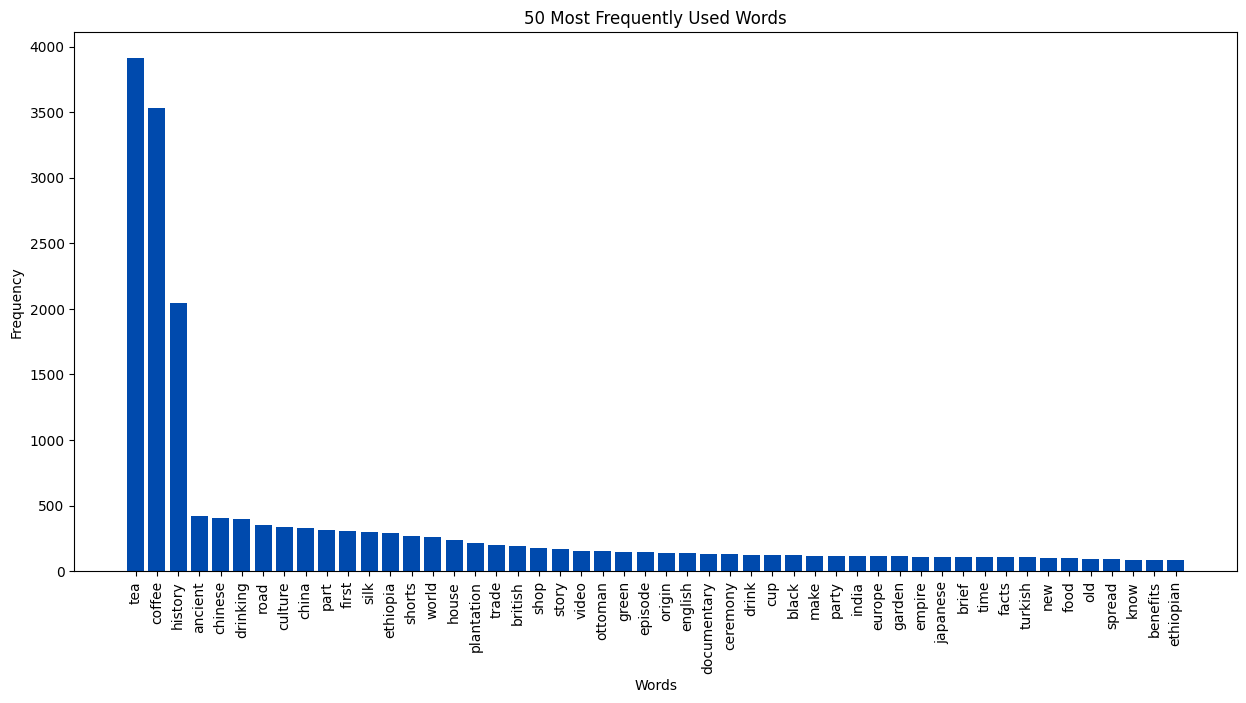

In [ ]:
plt.figure(figsize=(15, 7))
plt.bar(words, counts, color='#004aad')
plt.title('50 Most Frequently Used Words')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

## **Word cloud**

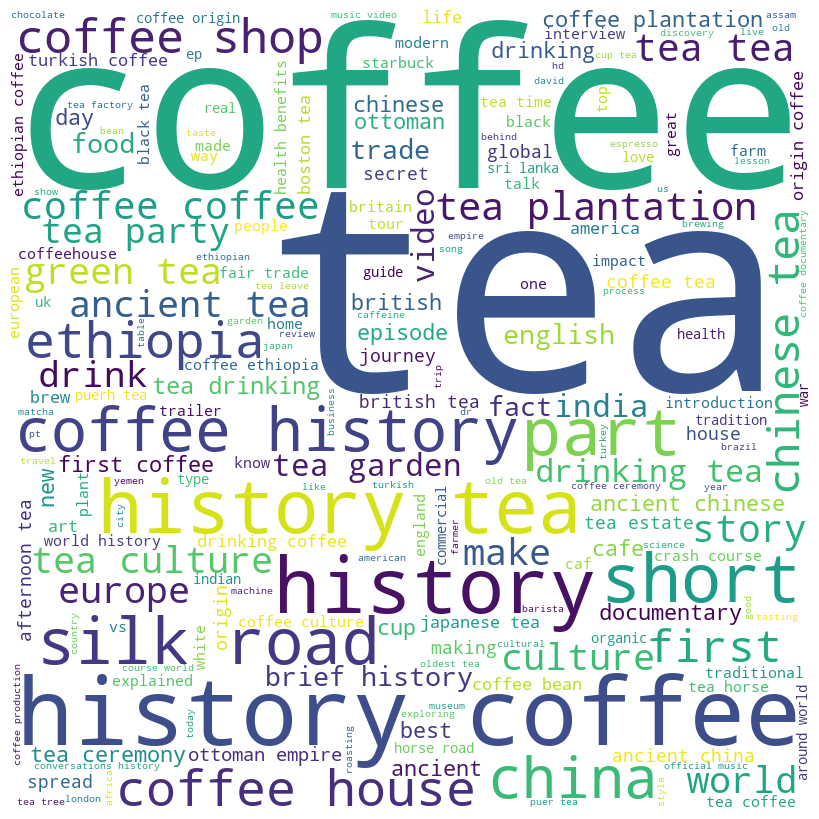

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(' '.join(video_df['cleaned_text']))


plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [ ]:
video_df.head(5)

title               channel  \
0   The History Of Tea - Historia [Animated History]  Mechanix Illustrated   
1           Tea: How Britain Screwed India and China           Elliot Sang   
2  The History of Tea | The Origin Of Tea | Tea's...            KidsMathTV   
3  Robert Fortune on How Tea Was Stolen From the ...        SLICE Full Doc   
4  How did tea become so popular in Great Britain...      Absolute History   

               published at     video id likes       dislikes comments  \
0 2023-02-19 21:28:20+00:00  TX78tKMdJsA   287  Not available       27   
1 2023-09-08 17:00:11+00:00  2-1obrIBYN0  5730  Not available      357   
2 2023-01-09 11:03:57+00:00  N6uzMv9XpKY   108  Not available        0   
3 2024-07-03 12:30:21+00:00  YbqtP-lH734  1552  Not available      192   
4 2023-04-05 21:00:24+00:00  uhLl7YxQnjA  7291  Not available       85   

  post type       date      time  \
0       tea 2023-02-19  21:28:20   
1       tea 2023-09-08  17:00:11   
2       tea 2023-01-09  11:03:57   
3       tea 2024-07-03  12:30:21   
4       tea 2023-04-05  21:00:24   

                                        cleaned_text  \
0              history tea historia animated history   
1                    tea britain screwed india china   
2  history tea origin tea teas ancient beginnings...   
3  robert fortune tea stolen chinese full documen...   
4            tea become popular great britain shorts   

                                      processed_text  
0        [history, tea, historia, animated, history]  
1              [tea, britain, screwed, india, china]  
2  [history, tea, origin, tea, teas, ancient, beg...  
3  [robert, fortune, tea, stolen, chinese, full, ...  
4     [tea, become, popular, great, britain, shorts]

In [ ]:
video_df['likes'] = pd.to_numeric(video_df['likes'], errors='coerce')
video_df['comments'] = pd.to_numeric(video_df['comments'], errors='coerce')

## Calculating engagement rate

In [ ]:
video_df['total_interactions'] = video_df['likes'] + video_df['comments']
max_interactions = video_df['total_interactions'].max()
video_df['engagement_rate'] = (video_df['total_interactions'] / max_interactions) * 100
print(video_df[['title', 'engagement_rate']])

                                                  title  engagement_rate
0      The History Of Tea - Historia [Animated History]         0.002321
1              Tea: How Britain Screwed India and China         0.044994
2     The History of Tea | The Origin Of Tea | Tea's...         0.000798
3     Robert Fortune on How Tea Was Stolen From the ...         0.012891
4     How did tea become so popular in Great Britain...         0.054522
...                                                 ...              ...
9674      Dr. Todd Mikuriya Discusses Medical Marijuana         0.000517
9675  PART 1 OPENING PLENARY WITH HOWARD RHEINGOLD A...         0.000007
9676  EWB - Interview with Brighton thoughts on poverty         0.000037
9677  SFIII: 3S - Q & Chun Li [Fubarduck] vs Chun Li...         0.000111
9678  Big Seminar 3 - Armand Morin Interviews John C...         0.000007

[9679 rows x 2 columns]


In [ ]:
video_df.head(10)

title  \
0   The History Of Tea - Historia [Animated History]   
1           Tea: How Britain Screwed India and China   
2  The History of Tea | The Origin Of Tea | Tea's...   
3  Robert Fortune on How Tea Was Stolen From the ...   
4  How did tea become so popular in Great Britain...   
5                             A brief history of tea   
6                         Commoner Queens of England   
7             Anne, Queen of Great Britain & Ireland   
8         The History Of Afternoon Tea | Documentary   
9  An Introduction to Tea in East Asia - ASMR His...   

                                 channel              published at  \
0                   Mechanix Illustrated 2023-02-19 21:28:20+00:00   
1                            Elliot Sang 2023-09-08 17:00:11+00:00   
2                             KidsMathTV 2023-01-09 11:03:57+00:00   
3                         SLICE Full Doc 2024-07-03 12:30:21+00:00   
4                       Absolute History 2023-04-05 21:00:24+00:00   
5                                   Neom 2022-10-25 19:00:04+00:00   
6  History Tea Time with Lindsay Holiday 2024-04-16 16:00:05+00:00   
7  History Tea Time with Lindsay Holiday 2024-09-03 16:00:41+00:00   
8                    HistoricHospitality 2024-02-23 17:00:11+00:00   
9                         ASMR Historian 2024-02-28 07:00:10+00:00   

      video id   likes       dislikes  comments post type       date  \
0  TX78tKMdJsA   287.0  Not available      27.0       tea 2023-02-19   
1  2-1obrIBYN0  5730.0  Not available     357.0       tea 2023-09-08   
2  N6uzMv9XpKY   108.0  Not available       0.0       tea 2023-01-09   
3  YbqtP-lH734  1552.0  Not available     192.0       tea 2024-07-03   
4  uhLl7YxQnjA  7291.0  Not available      85.0       tea 2023-04-05   
5  9wfj-E5s-ws    94.0  Not available      65.0       tea 2022-10-25   
6  8LEoH6SSCwM  6196.0  Not available     556.0       tea 2024-04-16   
7  jcNBX4UvHmk  3777.0  Not available     222.0       tea 2024-09-03   
8  caFzG39lBmE   192.0  Not available      35.0       tea 2024-02-23   
9  TUvEMzi7r10    67.0  Not available      13.0       tea 2024-02-28   

       time                                       cleaned_text  \
0  21:28:20              history tea historia animated history   
1  17:00:11                    tea britain screwed india china   
2  11:03:57  history tea origin tea teas ancient beginnings...   
3  12:30:21  robert fortune tea stolen chinese full documen...   
4  21:00:24            tea become popular great britain shorts   
5  19:00:04                                  brief history tea   
6  16:00:05                            commoner queens england   
7  16:00:41                   anne queen great britain ireland   
8  17:00:11                  history afternoon tea documentary   
9  07:00:10   introduction tea east asia asmr history learning   

                                      processed_text  total_interactions  \
0        [history, tea, historia, animated, history]               314.0   
1              [tea, britain, screwed, india, china]              6087.0   
2  [history, tea, origin, tea, teas, ancient, beg...               108.0   
3  [robert, fortune, tea, stolen, chinese, full, ...              1744.0   
4     [tea, become, popular, great, britain, shorts]              7376.0   
5                              [brief, history, tea]               159.0   
6                        [commoner, queens, england]              6752.0   
7             [anne, queen, great, britain, ireland]              3999.0   
8             [history, afternoon, tea, documentary]               227.0   
9  [introduction, tea, east, asia, asmr, history,...                80.0   

   engagement_rate  
0         0.002321  
1         0.044994  
2         0.000798  
3         0.012891  
4         0.054522  
5         0.001175  
6         0.049910  
7         0.029560  
8         0.001678  
9         0.000591

In [ ]:
video_df['engagement'] = video_df['likes'] + video_df['comments']

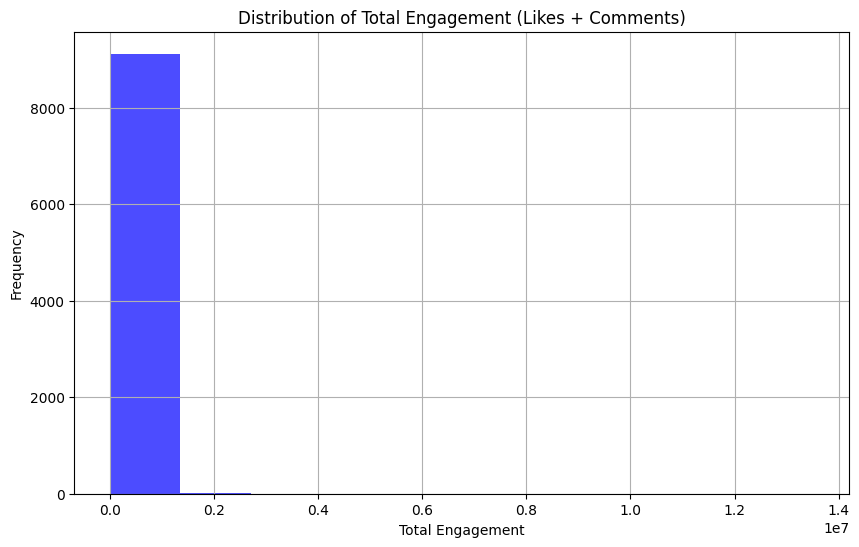

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(video_df['engagement'], bins=10, color='blue', alpha=0.7)
plt.title('Distribution of Total Engagement (Likes + Comments)')
plt.xlabel('Total Engagement')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
video_df.head(10)

title  \
0   The History Of Tea - Historia [Animated History]   
1           Tea: How Britain Screwed India and China   
2  The History of Tea | The Origin Of Tea | Tea's...   
3  Robert Fortune on How Tea Was Stolen From the ...   
4  How did tea become so popular in Great Britain...   
5                             A brief history of tea   
6                         Commoner Queens of England   
7             Anne, Queen of Great Britain & Ireland   
8         The History Of Afternoon Tea | Documentary   
9  An Introduction to Tea in East Asia - ASMR His...   

                                 channel              published at  \
0                   Mechanix Illustrated 2023-02-19 21:28:20+00:00   
1                            Elliot Sang 2023-09-08 17:00:11+00:00   
2                             KidsMathTV 2023-01-09 11:03:57+00:00   
3                         SLICE Full Doc 2024-07-03 12:30:21+00:00   
4                       Absolute History 2023-04-05 21:00:24+00:00   
5                                   Neom 2022-10-25 19:00:04+00:00   
6  History Tea Time with Lindsay Holiday 2024-04-16 16:00:05+00:00   
7  History Tea Time with Lindsay Holiday 2024-09-03 16:00:41+00:00   
8                    HistoricHospitality 2024-02-23 17:00:11+00:00   
9                         ASMR Historian 2024-02-28 07:00:10+00:00   

      video id   likes       dislikes  comments post type       date  \
0  TX78tKMdJsA   287.0  Not available      27.0       tea 2023-02-19   
1  2-1obrIBYN0  5730.0  Not available     357.0       tea 2023-09-08   
2  N6uzMv9XpKY   108.0  Not available       0.0       tea 2023-01-09   
3  YbqtP-lH734  1552.0  Not available     192.0       tea 2024-07-03   
4  uhLl7YxQnjA  7291.0  Not available      85.0       tea 2023-04-05   
5  9wfj-E5s-ws    94.0  Not available      65.0       tea 2022-10-25   
6  8LEoH6SSCwM  6196.0  Not available     556.0       tea 2024-04-16   
7  jcNBX4UvHmk  3777.0  Not available     222.0       tea 2024-09-03   
8  caFzG39lBmE   192.0  Not available      35.0       tea 2024-02-23   
9  TUvEMzi7r10    67.0  Not available      13.0       tea 2024-02-28   

       time                                       cleaned_text  \
0  21:28:20              history tea historia animated history   
1  17:00:11                    tea britain screwed india china   
2  11:03:57  history tea origin tea teas ancient beginnings...   
3  12:30:21  robert fortune tea stolen chinese full documen...   
4  21:00:24            tea become popular great britain shorts   
5  19:00:04                                  brief history tea   
6  16:00:05                            commoner queens england   
7  16:00:41                   anne queen great britain ireland   
8  17:00:11                  history afternoon tea documentary   
9  07:00:10   introduction tea east asia asmr history learning   

                                      processed_text  total_interactions  \
0        [history, tea, historia, animated, history]               314.0   
1              [tea, britain, screwed, india, china]              6087.0   
2  [history, tea, origin, tea, teas, ancient, beg...               108.0   
3  [robert, fortune, tea, stolen, chinese, full, ...              1744.0   
4     [tea, become, popular, great, britain, shorts]              7376.0   
5                              [brief, history, tea]               159.0   
6                        [commoner, queens, england]              6752.0   
7             [anne, queen, great, britain, ireland]              3999.0   
8             [history, afternoon, tea, documentary]               227.0   
9  [introduction, tea, east, asia, asmr, history,...                80.0   

   engagement_rate  engagement  
0         0.002321       314.0  
1         0.044994      6087.0  
2         0.000798       108.0  
3         0.012891      1744.0  
4         0.054522      7376.0  
5         0.001175       159.0  
6         0.049910      6752.0  
7         0.029560      3999.0  
8    

## Engagement Rate Distribution Over Time

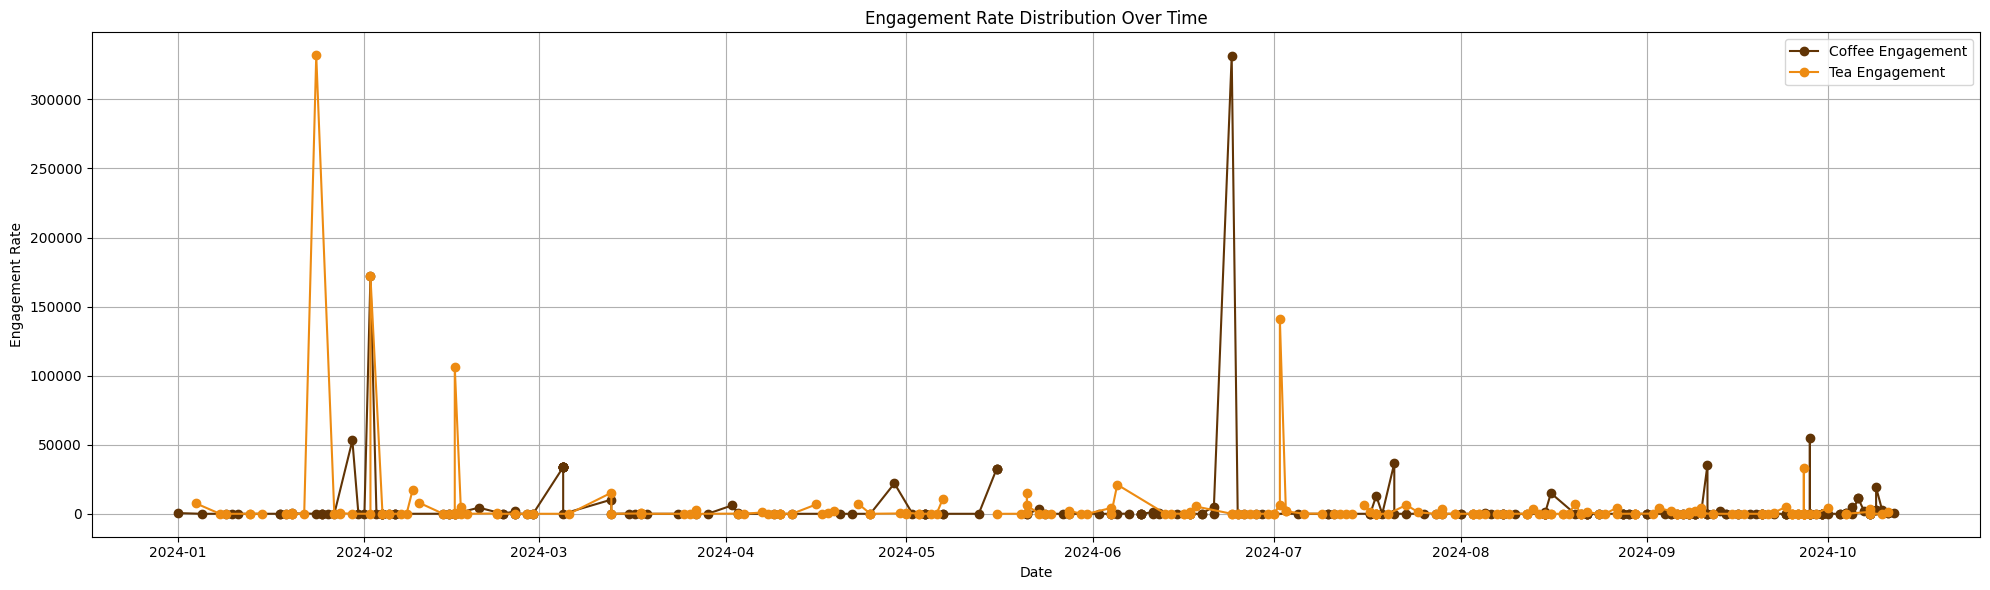

In [ ]:
video_df['date'] = pd.to_datetime(video_df['date'])

video_df = video_df[video_df['date'] >= '2024-01-01']
video_df.sort_values('date', inplace=True)

color_map = {
    'tea': '#ed8b12',
    'coffee': '#613405'
}

plt.figure(figsize=(20, 6))

for post_type, group in video_df.groupby('post type'):
    plt.plot(group['date'], group['engagement'], label=f'{post_type.capitalize()} Engagement',
             marker='o', linestyle='-', color=color_map[post_type])

plt.title('Engagement Rate Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Engagement Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Engagement Rate Distribution Over Time (v2)

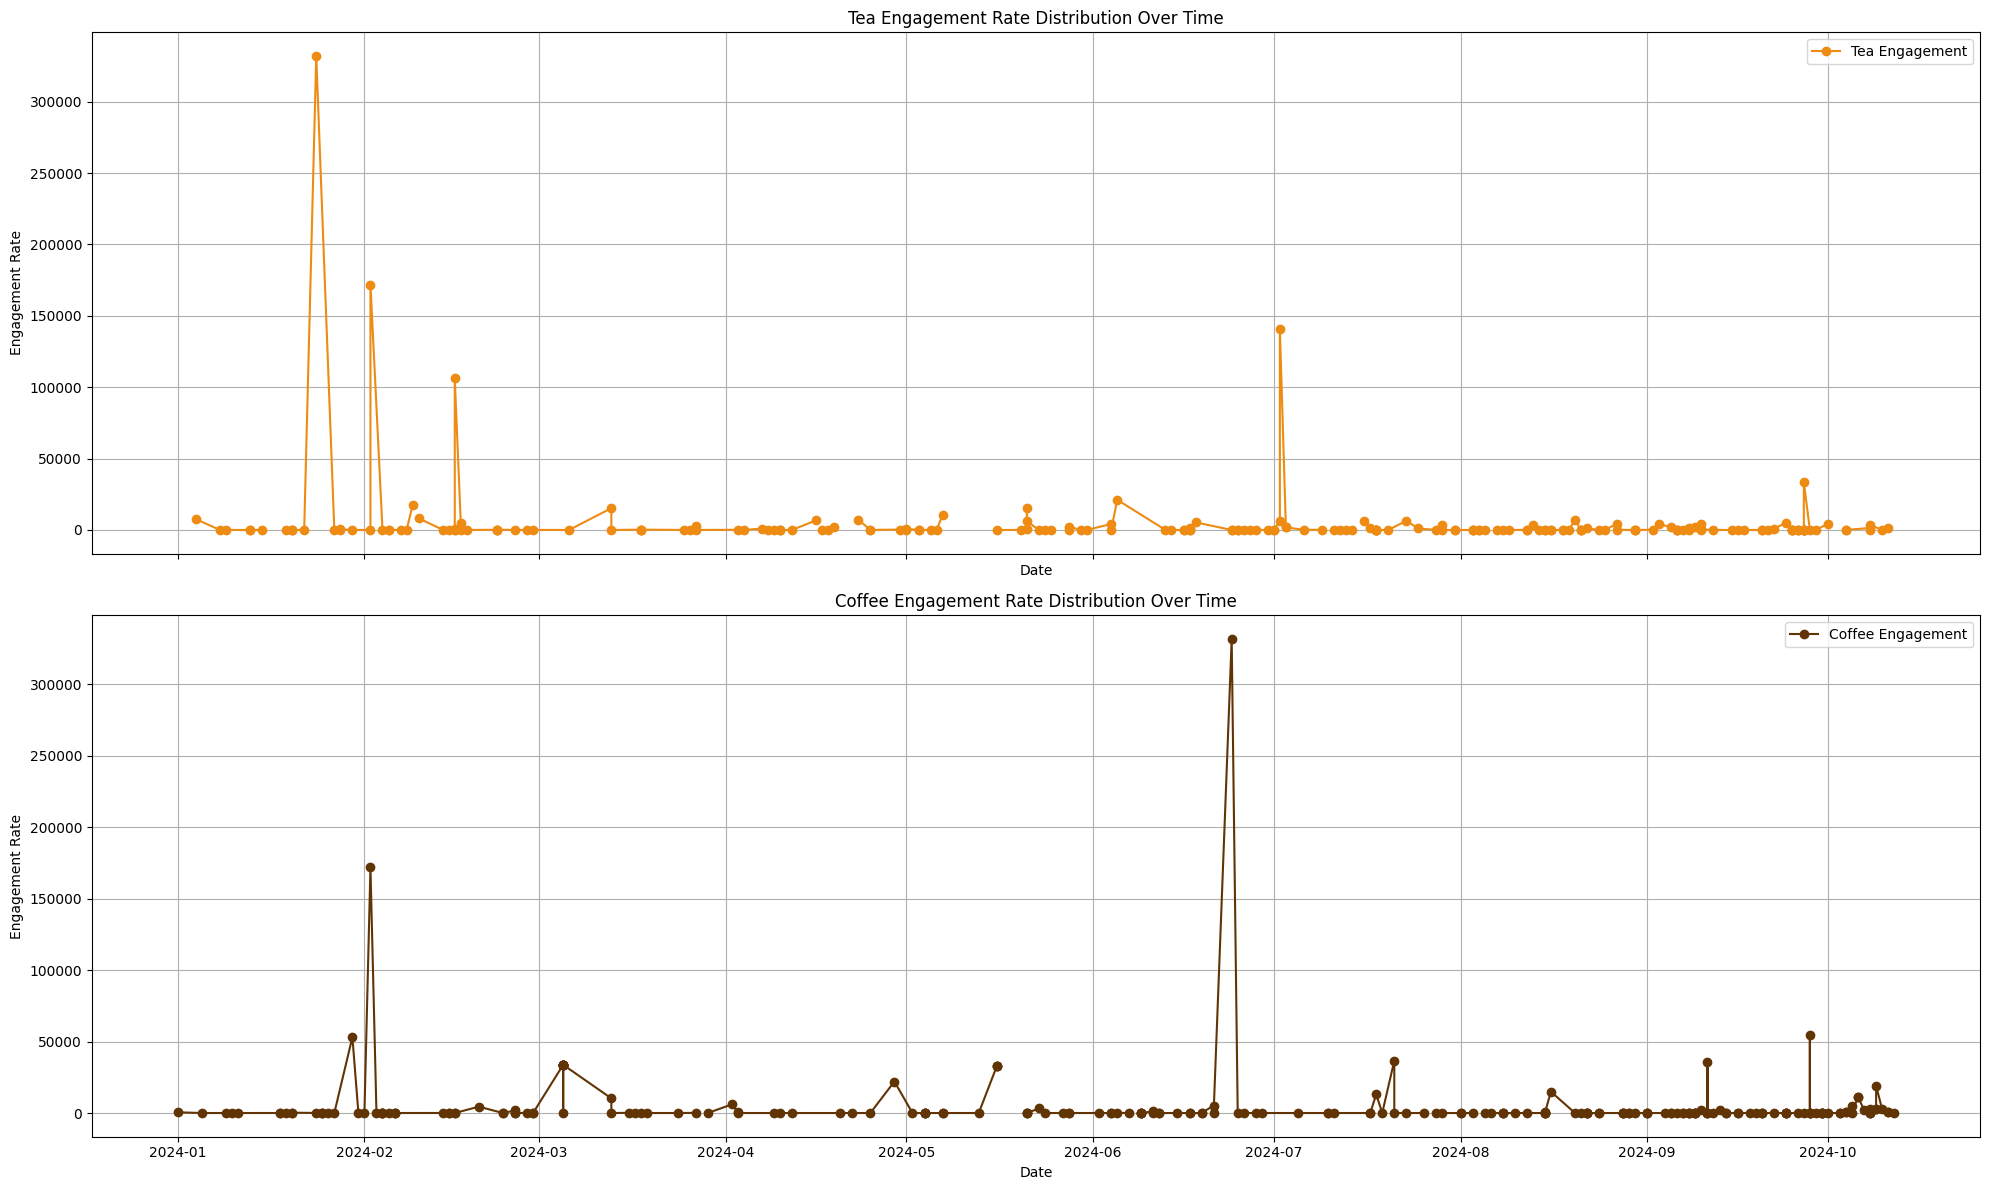

In [ ]:
video_df['date'] = pd.to_datetime(video_df['date'])
video_df = video_df[video_df['date'] >= '2024-01-01']
video_df.sort_values('date', inplace=True)

color_map = {
    'tea': '#ed8b12',
    'coffee': '#613405'
}

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 12), sharex=True)

for i, post_type in enumerate(['tea', 'coffee']):

    post_data = video_df[video_df['post type'] == post_type]

    axes[i].plot(post_data['date'], post_data['engagement'], 'o-', label=f"{post_type.capitalize()} Engagement", color=color_map[post_type])
    axes[i].set_title(f"{post_type.capitalize()} Engagement Rate Distribution Over Time")
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Engagement Rate')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


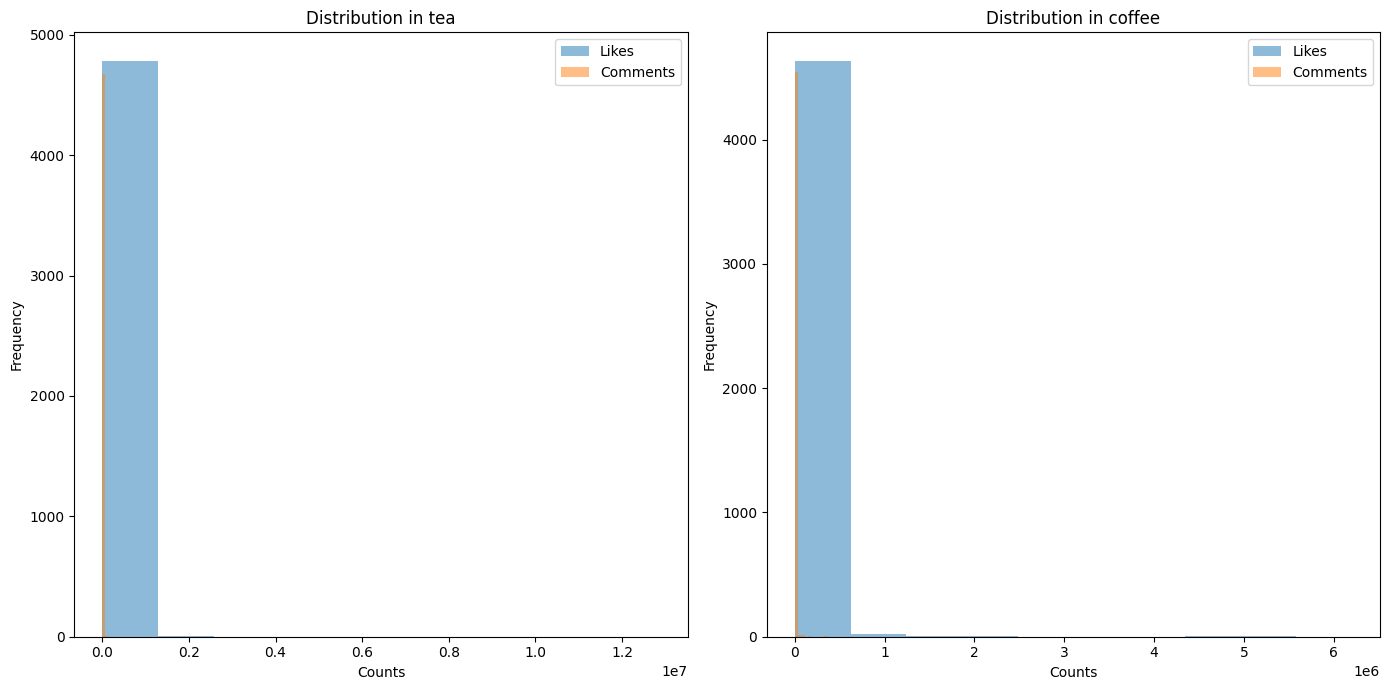

In [ ]:

plt.figure(figsize=(14, 7))

post_types = video_df['post type'].unique()

for i, post_type in enumerate(post_types, 1):
    plt.subplot(1, len(post_types), i)
    subset = video_df[video_df['post type'] == post_type]

    plt.hist(subset['likes'], bins=10, alpha=0.5, label='Likes')
    plt.hist(subset['comments'], bins=10, alpha=0.5, label='Comments')
    plt.title(f'Distribution in {post_type}')
    plt.xlabel('Counts')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()


## **Sentiment Analysis**

In [ ]:
tea_positive_words = [
            'aromatic', 'flavorful', 'soothing', 'refreshing', 'energizing', 'calming', 'invigorating', 'comforting',
            'delicious', 'satisfying', 'robust', 'smooth', 'rich', 'warm', 'relaxing', 'tasty', 'revitalizing',
            'uplifting', 'enjoyable', 'perfect', 'exquisite', 'fragrant', 'premium', 'fine', 'balanced', 'harmonious',
            'pure'
]

tea_negative_words = [
            'bitter', 'stale', 'burnt', 'overpriced', 'bland', 'weak', 'watery', 'cold', 'unpleasant', 'insipid',
            'tasteless', 'acidic', 'artificial', 'sour', 'diluted', 'overbrewed', 'undercooked', 'overcooked', 'spoiled',
            'harsh', 'disappointing', 'flat', 'cheap', 'unbalanced', 'sickening', 'distasteful', 'chalky', 'excessive',
            'unrefined', 'overpowering'
]

coffee_positive_words = [
            'aromatic', 'flavorful', 'energizing', 'robust', 'bold', 'smooth', 'rich', 'full-bodied', 'satisfying',
            'delicious', 'strong', 'invigorating', 'premium', 'warm', 'tasty', 'perfect', 'refreshing', 'fresh',
            'exquisite', 'balanced', 'pure', 'harmonious', 'refined', 'uplifting'
]

coffee_negative_words = [
            'bitter', 'burnt', 'stale', 'overpriced', 'bland', 'weak', 'watery', 'cold', 'acidic', 'sour',
            'tasteless', 'overbrewed', 'artificial', 'harsh', 'spoiled', 'disappointing', 'flat', 'cheap',
            'unbalanced', 'chalky', 'overpowering', 'distasteful', 'excessive', 'unrefined', 'sickening'
]

In [ ]:
selected_columns = ['date', 'time', 'processed_text']
new_df = video_df[selected_columns]

In [ ]:
new_df.head(10)

date      time                                     processed_text
0 2023-02-19  21:28:20        [history, tea, historia, animated, history]
1 2023-09-08  17:00:11              [tea, britain, screwed, india, china]
2 2023-01-09  11:03:57  [history, tea, origin, tea, teas, ancient, beg...
3 2024-07-03  12:30:21  [robert, fortune, tea, stolen, chinese, full, ...
4 2023-04-05  21:00:24     [tea, become, popular, great, britain, shorts]
5 2022-10-25  19:00:04                              [brief, history, tea]
6 2024-04-16  16:00:05                        [commoner, queens, england]
7 2024-09-03  16:00:41             [anne, queen, great, britain, ireland]
8 2024-02-23  17:00:11             [history, afternoon, tea, documentary]
9 2024-02-28  07:00:10  [introduction, tea, east, asia, asmr, history,...

Calculate Sentiment Tea

In [ ]:
def calculate_sentiment(text_data):
    if isinstance(text_data, str):
        text_words = text_data.lower().split()
    elif isinstance(text_data, list):
        text_words = text_data
    else:
        return 0

    positive_count = sum(1 for word in text_words if word in tea_positive_words)
    negative_count = sum(1 for word in text_words if word in tea_negative_words)

    return positive_count - negative_count

In [ ]:
new_df['sentiment_score_tea'] = new_df['processed_text'].apply(calculate_sentiment)
new_df['sentiment_class_tea'] = new_df['sentiment_score_tea'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
print(new_df[['processed_text', 'sentiment_score_tea', 'sentiment_class_tea']])

                                         processed_text  sentiment_score_tea  \
0           [history, tea, historia, animated, history]                    0   
1                 [tea, britain, screwed, india, china]                    0   
2     [history, tea, origin, tea, teas, ancient, beg...                    0   
3     [robert, fortune, tea, stolen, chinese, full, ...                    0   
4        [tea, become, popular, great, britain, shorts]                    0   
...                                                 ...                  ...   
9674  [dr, todd, mikuriya, discusses, medical, marij...                    0   
9675  [part, opening, plenary, howard, rheingold, pa...                    0   
9676      [ewb, interview, brighton, thoughts, poverty]                    0   
9677  [sfiii, chun, li, fubarduck, vs, chun, li, hen...                    0   
9678  [big, seminar, armand, morin, interviews, john...                    0   

     sentiment_class_tea  
0           

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2136\3963722967.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['sentiment_score_tea'] = new_df['processed_text'].apply(calculate_sentiment)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2136\3963722967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['sentiment_class_tea'] = new_df['sentiment_score_tea'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))


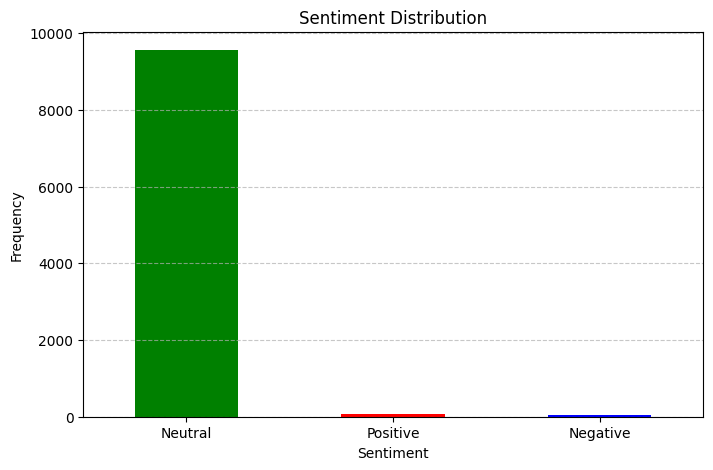

In [ ]:
sentiment_counts = new_df['sentiment_class_tea'].value_counts()

plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])

plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
def sentiment_analysis(text):
    if isinstance(text, list):
        text = ' '.join(text)
    elif not isinstance(text, str):
        return 0, 0

    text_words = text.lower().split()

    tea_positive_count = sum(1 for word in text_words if word in tea_positive_words)
    tea_negative_count = sum(1 for word in text_words if word in tea_negative_words)

    return tea_positive_count, tea_negative_count

new_df['tea_positive_count'], new_df['tea_negative_count'] = zip(*new_df['processed_text'].apply(sentiment_analysis))

print(new_df.head(10))

        date      time                                     processed_text  \
0 2023-02-19  21:28:20        [history, tea, historia, animated, history]   
1 2023-09-08  17:00:11              [tea, britain, screwed, india, china]   
2 2023-01-09  11:03:57  [history, tea, origin, tea, teas, ancient, beg...   
3 2024-07-03  12:30:21  [robert, fortune, tea, stolen, chinese, full, ...   
4 2023-04-05  21:00:24     [tea, become, popular, great, britain, shorts]   
5 2022-10-25  19:00:04                              [brief, history, tea]   
6 2024-04-16  16:00:05                        [commoner, queens, england]   
7 2024-09-03  16:00:41             [anne, queen, great, britain, ireland]   
8 2024-02-23  17:00:11             [history, afternoon, tea, documentary]   
9 2024-02-28  07:00:10  [introduction, tea, east, asia, asmr, history,...   

   sentiment_score_tea sentiment_class_tea  tea_positive_count  \
0                    0             Neutral                   0   
1                   

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2136\1720871701.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tea_positive_count'], new_df['tea_negative_count'] = zip(*new_df['processed_text'].apply(sentiment_analysis))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2136\1720871701.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tea_positive_count'], new_df['tea_negative_count'] = zip(*new_df['processed_text'].apply(sentiment_analysis))


In [ ]:
if len(new_df) > 150:
    plot_df = new_df.iloc[:150]
else:
    plot_df = new_df

plot_df['tea_neutral_score'] = 0
plot_df.loc[plot_df['tea_positive_count'] == plot_df['tea_negative_count'], 'neutral_score'] = 0

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2136\2066701779.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['tea_neutral_score'] = 0
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2136\2066701779.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.loc[plot_df['tea_positive_count'] == plot_df['tea_negative_count'], 'neutral_score'] = 0


Calculate Sentiment Coffee

In [ ]:
def calculate_sentiment(text_data):
    if isinstance(text_data, str):
        text_words = text_data.lower().split()
    elif isinstance(text_data, list):
        text_words = text_data
    else:
        return 0

    positive_count = sum(1 for word in text_words if word in coffee_positive_words)
    negative_count = sum(1 for word in text_words if word in coffee_negative_words)

    return positive_count - negative_count

In [ ]:
new_df['sentiment_score_coffee'] = new_df['processed_text'].apply(calculate_sentiment)
new_df['sentiment_class_coffee'] = new_df['sentiment_score_coffee'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
print(new_df[['processed_text', 'sentiment_score_coffee', 'sentiment_class_coffee']])

                                         processed_text  \
0           [history, tea, historia, animated, history]   
1                 [tea, britain, screwed, india, china]   
2     [history, tea, origin, tea, teas, ancient, beg...   
3     [robert, fortune, tea, stolen, chinese, full, ...   
4        [tea, become, popular, great, britain, shorts]   
...                                                 ...   
9674  [dr, todd, mikuriya, discusses, medical, marij...   
9675  [part, opening, plenary, howard, rheingold, pa...   
9676      [ewb, interview, brighton, thoughts, poverty]   
9677  [sfiii, chun, li, fubarduck, vs, chun, li, hen...   
9678  [big, seminar, armand, morin, interviews, john...   

      sentiment_score_coffee sentiment_class_coffee  
0                          0                Neutral  
1                          0                Neutral  
2                          0                Neutral  
3                          0                Neutral  
4                    

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2136\481251336.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['sentiment_score_coffee'] = new_df['processed_text'].apply(calculate_sentiment)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2136\481251336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['sentiment_class_coffee'] = new_df['sentiment_score_coffee'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))


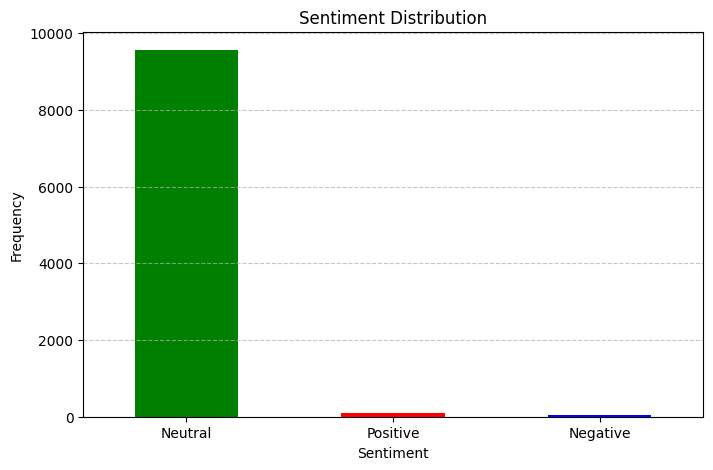

In [ ]:
sentiment_counts = new_df['sentiment_class_coffee'].value_counts()

plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])

plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
new_df.head(10)

date      time                                     processed_text  \
0 2023-02-19  21:28:20        [history, tea, historia, animated, history]   
1 2023-09-08  17:00:11              [tea, britain, screwed, india, china]   
2 2023-01-09  11:03:57  [history, tea, origin, tea, teas, ancient, beg...   
3 2024-07-03  12:30:21  [robert, fortune, tea, stolen, chinese, full, ...   
4 2023-04-05  21:00:24     [tea, become, popular, great, britain, shorts]   
5 2022-10-25  19:00:04                              [brief, history, tea]   
6 2024-04-16  16:00:05                        [commoner, queens, england]   
7 2024-09-03  16:00:41             [anne, queen, great, britain, ireland]   
8 2024-02-23  17:00:11             [history, afternoon, tea, documentary]   
9 2024-02-28  07:00:10  [introduction, tea, east, asia, asmr, history,...   

   sentiment_score_tea sentiment_class_tea  tea_positive_count  \
0                    0             Neutral                   0   
1                    0             Neutral                   0   
2                    0             Neutral                   0   
3                    0             Neutral                   0   
4                    0             Neutral                   0   
5                    0             Neutral                   0   
6                    0             Neutral                   0   
7                    0             Neutral                   0   
8                    0             Neutral                   0   
9                    0             Neutral                   0   

   tea_negative_count  sentiment_score_coffee sentiment_class_coffee  
0                   0                       0                Neutral  
1                   0                       0                Neutral  
2                   0                       0                Neutral  
3                   0                       0                Neutral  
4                   0                       0                Neutral  
5                   0                       0                Neutral  
6                   0                       0                Neutral  
7                   0                       0                Neutral  
8                   0                       0                Neutral  
9                   0                       0                Neutral

In [ ]:
def sentiment_analysis(text):
    if isinstance(text, list):
        text = ' '.join(text)
    elif not isinstance(text, str):
        return 0, 0

    text_words = text.lower().split()

    coffee_positive_count = sum(1 for word in text_words if word in tea_positive_words)
    coffee_negative_count = sum(1 for word in text_words if word in tea_negative_words)

    return coffee_positive_count, coffee_negative_count

new_df['coffee_positive_count'], new_df['coffee_negative_count'] = zip(*new_df['processed_text'].apply(sentiment_analysis))

print(new_df.head(10))

        date      time                                     processed_text  \
0 2023-02-19  21:28:20        [history, tea, historia, animated, history]   
1 2023-09-08  17:00:11              [tea, britain, screwed, india, china]   
2 2023-01-09  11:03:57  [history, tea, origin, tea, teas, ancient, beg...   
3 2024-07-03  12:30:21  [robert, fortune, tea, stolen, chinese, full, ...   
4 2023-04-05  21:00:24     [tea, become, popular, great, britain, shorts]   
5 2022-10-25  19:00:04                              [brief, history, tea]   
6 2024-04-16  16:00:05                        [commoner, queens, england]   
7 2024-09-03  16:00:41             [anne, queen, great, britain, ireland]   
8 2024-02-23  17:00:11             [history, afternoon, tea, documentary]   
9 2024-02-28  07:00:10  [introduction, tea, east, asia, asmr, history,...   

   sentiment_score_tea sentiment_class_tea  tea_positive_count  \
0                    0             Neutral                   0   
1                   

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2136\144853640.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['coffee_positive_count'], new_df['coffee_negative_count'] = zip(*new_df['processed_text'].apply(sentiment_analysis))


In [ ]:
if len(new_df) > 150:
    plot_df = new_df.iloc[:150]
else:
    plot_df = new_df

plot_df['coffee_neutral_score'] = 0
plot_df.loc[plot_df['coffee_positive_count'] == plot_df['coffee_negative_count'], 'neutral_score'] = 0

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2136\2529236278.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['coffee_neutral_score'] = 0
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2136\2529236278.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.loc[plot_df['coffee_positive_count'] == plot_df['coffee_negative_count'], 'neutral_score'] = 0


In [ ]:
selected_columns = ['date', 'processed_text']
df3 = video_df[selected_columns]
df3.head(5)

date                                     processed_text
0 2023-02-19        [history, tea, historia, animated, history]
1 2023-09-08              [tea, britain, screwed, india, china]
2 2023-01-09  [history, tea, origin, tea, teas, ancient, beg...
3 2024-07-03  [robert, fortune, tea, stolen, chinese, full, ...
4 2023-04-05     [tea, become, popular, great, britain, shorts]

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
df3['processed_text'] = df3['processed_text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

sia = SentimentIntensityAnalyzer()

df3['compound_score'] = df3['processed_text'].apply(lambda text: sia.polarity_scores(str(text))['compound'])
df3_subset = df3.iloc[:100]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2136\604528051.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['processed_text'] = df3['processed_text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2136\604528051.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['compound_score'] = df3['processed_text'].apply(lambda text: sia.polarity_scores(str(text))['compound'])


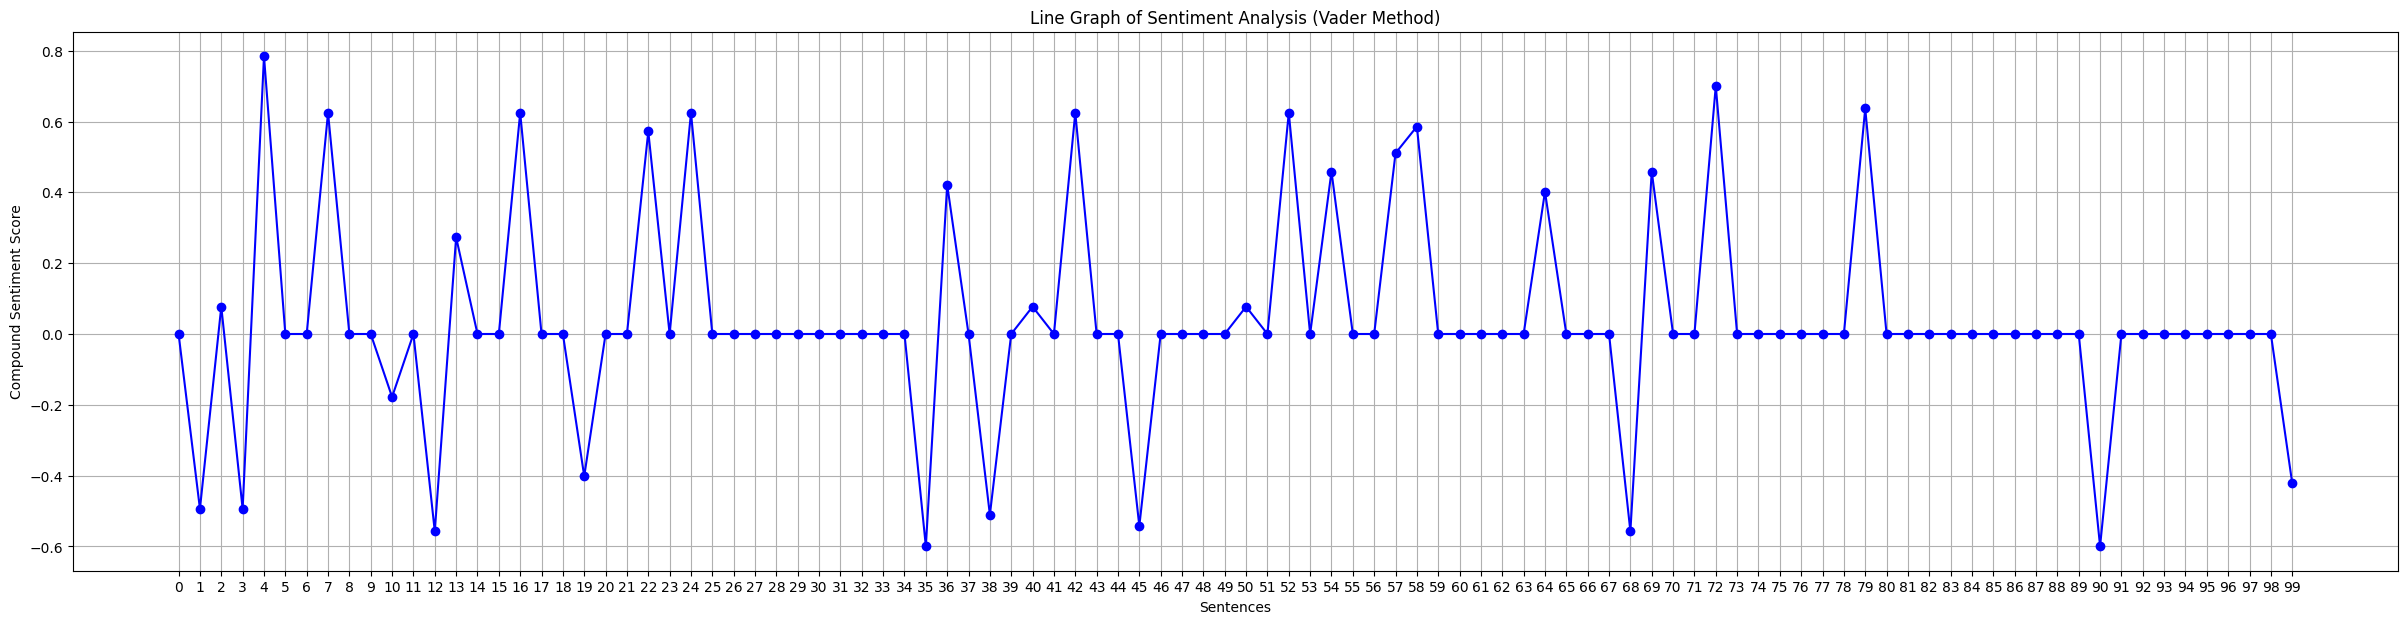

In [ ]:
plt.figure(figsize=(30, 7))
plt.plot(df3_subset.index, df3_subset['compound_score'], marker='o', linestyle='-', color='b')
plt.title('Line Graph of Sentiment Analysis (Vader Method)')
plt.xlabel('Sentences')
plt.ylabel('Compound Sentiment Score')
plt.xticks(ticks=df3_subset.index)
plt.grid(True)
plt.show()

## **Topic Modelling**

In [ ]:
selected_columns = ['date', 'processed_text']
df4 = video_df[selected_columns]
df4.head(5)

date                                     processed_text
0 2023-02-19        [history, tea, historia, animated, history]
1 2023-09-08              [tea, britain, screwed, india, china]
2 2023-01-09  [history, tea, origin, tea, teas, ancient, beg...
3 2024-07-03  [robert, fortune, tea, stolen, chinese, full, ...
4 2023-04-05     [tea, become, popular, great, britain, shorts]

In [ ]:
def preprocess(text):
    text = str(text)
    custom_stopwords = set(stopwords.words('english')) | {'http', 'https', 'www', 'com'}
    text = re.sub(r'[\d\W]+', ' ', text)
    lemma = WordNetLemmatizer()
    return [lemma.lemmatize(word) for word in text.lower().split() if word not in custom_stopwords and len(word) > 2]

df4['clean_text'] = df4['processed_text'].apply(preprocess)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2136\896926684.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['clean_text'] = df4['processed_text'].apply(preprocess)


In [ ]:
dictionary = corpora.Dictionary(df4['clean_text'])
doc_term_matrix = [dictionary.doc2bow(doc) for doc in df4['clean_text']]

In [ ]:
num_topics = 15
lda = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=15)

In [ ]:
import pandas as pd

topics_list = []
for idx, topic in enumerate(lda.print_topics(num_topics, num_words=10)):
    words = ' '.join(word.split('*')[1].replace('"', '').strip() for word in topic[1].split('+'))
    topics_list.append((idx, words))

print("------ Topic Modelling ------")
for idx, words in topics_list:
    print(f"Topic {idx}: {words}")


------ Topic Modelling ------
Topic 0: tea plantation garden first global estate century brazil plant museum
Topic 1: house part tea production music life video english introduction learn
Topic 2: documentary food cafe art secret home white travel blue explore
Topic 3: tea drinking ottoman empire fact benefit health impact talk short
Topic 4: short turkish europe tea made business oldest big tour king
Topic 5: coffee ethiopia origin make bean trade plantation ethiopian cup best
Topic 6: culture tea chinese world old around day farmer tasting people
Topic 7: journey interview cultural live family brain grow japan wild quality
Topic 8: tea road silk british green japanese brew ancient trade explained
Topic 9: episode starbucks time espresso minute full bbc market water truth
Topic 10: coffee first tea shop story india party america brewing city
Topic 11: making tree lecture modern good process caffeine west series study
Topic 12: spread video journal year commercial official asian jesses

In [ ]:
topics_df = pd.DataFrame(topics_list, columns=['Topic', 'Words'])
topics_df.head(15)

Topic                                              Words
0       0  tea plantation garden first global estate cent...
1       1  house part tea production music life video eng...
2       2  documentary food cafe art secret home white tr...
3       3  tea drinking ottoman empire fact benefit healt...
4       4  short turkish europe tea made business oldest ...
5       5  coffee ethiopia origin make bean trade plantat...
6       6  culture tea chinese world old around day farme...
7       7  journey interview cultural live family brain g...
8       8  tea road silk british green japanese brew anci...
9       9  episode starbucks time espresso minute full bb...
10     10  coffee first tea shop story india party americ...
11     11  making tree lecture modern good process caffei...
12     12  spread video journal year commercial official ...
13     13  tea china ancient world history chinese drink ...
14     14  history coffee tea part new brief farm love gu...

Word cloud topic modeling

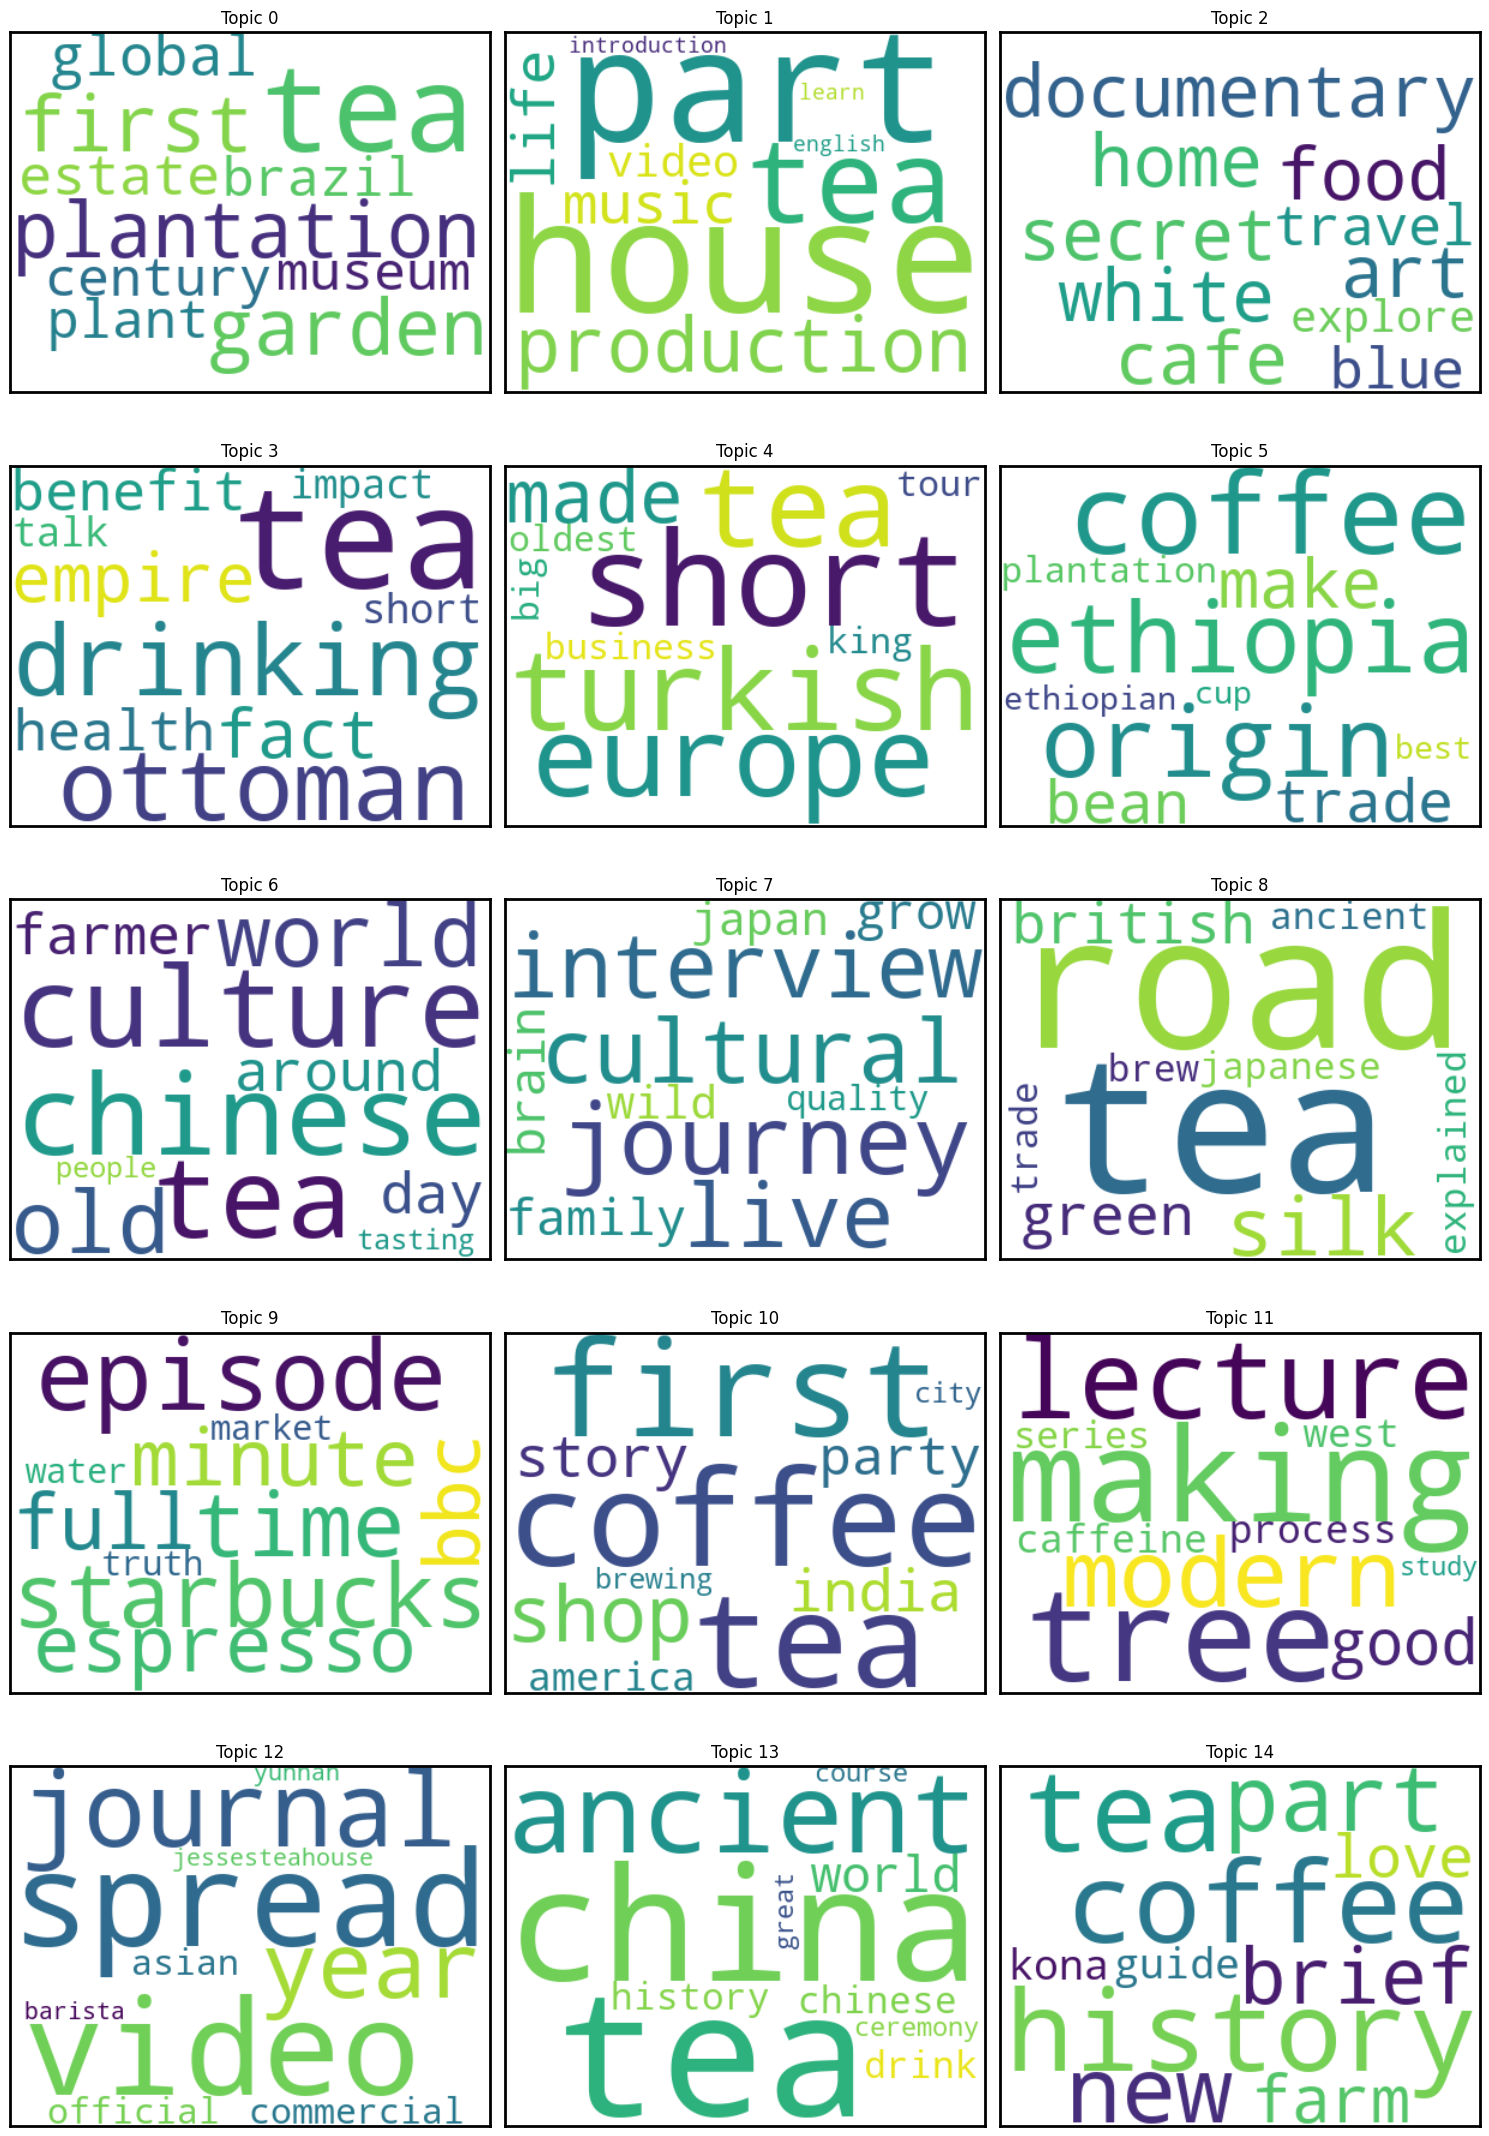

In [ ]:
fig, axes = plt.subplots(5, 3, figsize=(15, 22), subplot_kw={'xticks': [], 'yticks': [], 'frame_on': True})
axes = axes.flatten()

for i, row in topics_df.iterrows():
    wc = WordCloud(width=400, height=300, background_color='white', max_words=20).generate(row['Words'])

    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(f'Topic {row["Topic"]}')
    axes[i].axis('on')
    for spine in axes[i].spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_edgecolor('black')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Sentiment Analysis VADER

In [ ]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
def get_sentiment(title):
    return sia.polarity_scores(title)['compound']

video_df['sentiment'] = video_df['title'].apply(get_sentiment)

In [ ]:
tea_sentiment = video_df[video_df['post type'] == 'tea']['sentiment']
coffee_sentiment = video_df[video_df['post type'] == 'coffee']['sentiment']

print("Average sentiment for tea videos:", tea_sentiment.mean())
print("Average sentiment for coffee videos:", coffee_sentiment.mean())

Average sentiment for tea videos: 0.06211261261261262
Average sentiment for coffee videos: 0.05266176470588235


Sentiment Distribution

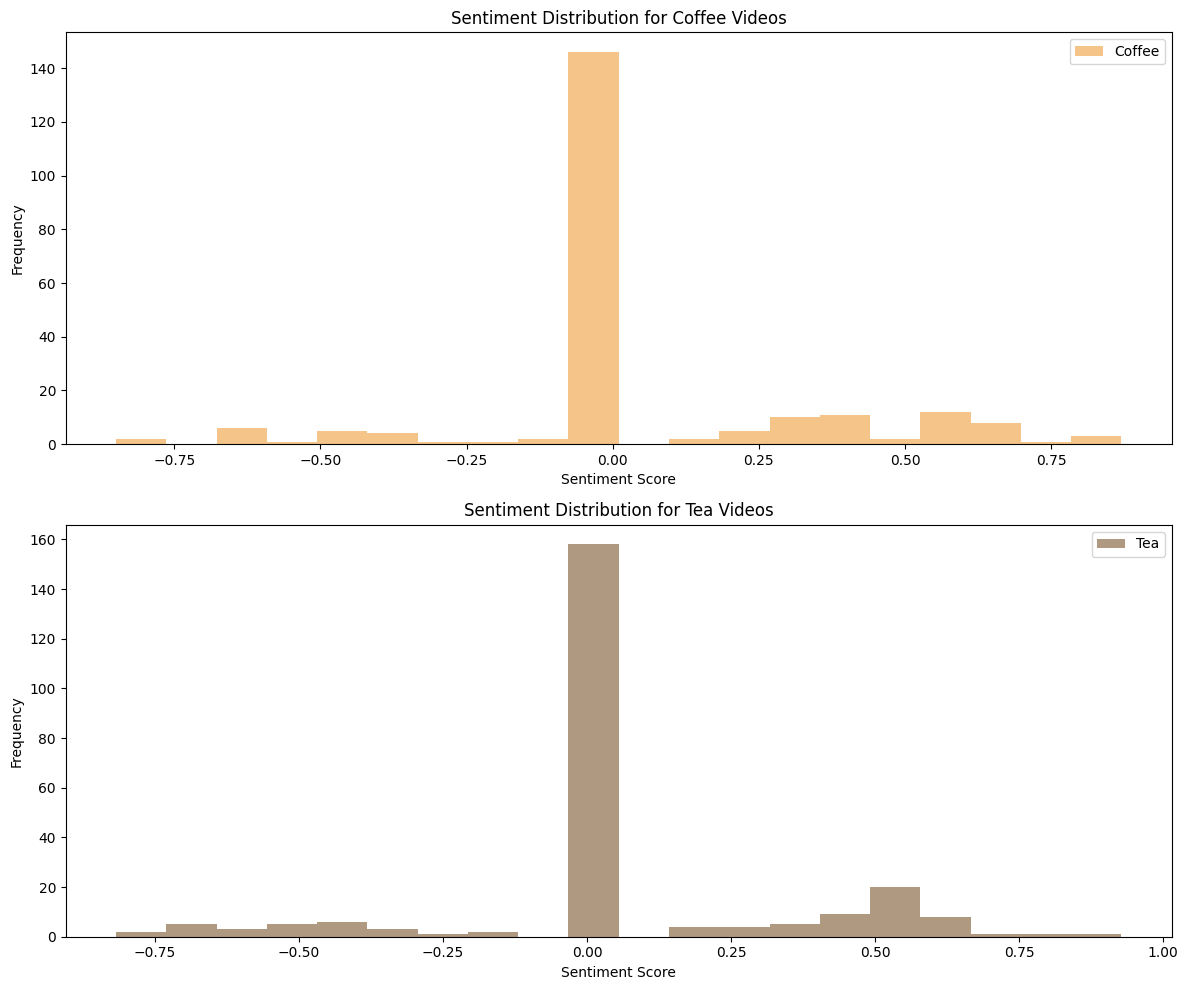

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.hist(coffee_sentiment, bins=20, alpha=0.5, label='Coffee', color='#ed8b12')
plt.title('Sentiment Distribution for Coffee Videos')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()


plt.subplot(2, 1, 2)
plt.hist(tea_sentiment, bins=20, alpha=0.5, label='Tea', color='#613405')
plt.title('Sentiment Distribution for Tea Videos')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()
